In [ ]:
import re
import dask
import json
import numpy
import xarray
import pyproj
import pandas
import requests
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import progress

import zarr
import fsspec
from pyproj import Transformer
from s3fs import S3FileSystem
from kerchunk.combine import MultiZarrToZarr

import rioxarray
from geocube.api.core import make_geocube

In [1]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=2, memory_limit='2GB') # per worker
    print(client.dashboard_link)

http://127.0.0.1:8787/status


## Load Forcing Data into Memory


In this notebook we'll be working with AORC v1.0 meteorological forcing. These data are publicly available for the entire CONUS, spanning from 1980 to 2020. Kerchunk header files have been created by the Alabama Water Institute team and this is an ongoing project. Please note that this jupyter notebook works for data within 2007-2019, but it cannot work with data prior to 2006.

In [ ]:
# define the selected watershed boundary 
wb_id = 'wb-2851655'

# define the year of interest
year=2010

In [ ]:
bucket = 's3://ciroh-nwm-zarr-retrospective-data-copy/noaa-nwm-retrospective-2-1-zarr-pds/forcing/'

# create an instace of the S3FileSystem class from s3fs
s3 = S3FileSystem(anon=True)
files = s3.ls(f'{bucket}{year}')  

new_files = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    new_files.append(new_name)
    

In [2]:
%%time
json_list = new_files[0:217] 

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['valid_time'])

d = mzz.translate()

backend_args = {"consolidated": False, "storage_options": {"fo": d}, "consolidated": False}

ds = xarray.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

ds = ds.squeeze(dim='Time')

CPU times: user 1.09 s, sys: 261 ms, total: 1.35 s
Wall time: 1.68 s


In [ ]:
# !wget https://thredds.hydroshare.org/thredds/fileServer/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc

In [ ]:
ds_meta = xarray.open_dataset('WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')
leny = len(ds_meta.y)
x = ds_meta.x.values
y = ds_meta.y.values

ds = ds.rename({'valid_time': 'time', 'south_north':'y', 'west_east':'x'})

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000)

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True);

## Add spatial reference to the model domain

In [ ]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'domain/v20.1/{wb_id}/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')


# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

# important step
# rechunk the dataset to solve the memory limit issue
ds = ds.chunk(chunks={'time': 1})

## Build Weights Variable

In [ ]:
#!wget 'https://lynker-spatial.s3.amazonaws.com/v20.1/forcing_grids.json'

In [ ]:
def assert_grids_equal(ds, weights_grid):
    dsx = ds.x.resolution
    dsy = ds.y.resolution
    assert dsx == weights_grid[0]['resX']
    assert dsy == weights_grid[0]['resY']
    
    assert ds.x.min().item() - dsx / 2 == weights_grid[0]['X1']
    assert ds.x.max().item() + dsx / 2 == weights_grid[0]['Xn']
    assert ds.y.min().item() - dsy / 2 == weights_grid[0]['Y1']
    assert ds.y.max().item() + dsy / 2 == weights_grid[0]['Yn']
    
    
    ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]
    assert ds_ncols   == weights_grid[0]['ncols']
    assert ds_nrows   == weights_grid[0]['nrows']

    #ds_wkt = ds.spatial_ref.crs_wkt
    #crs = wgrid[0]['crs']

    return True

In [3]:
wgrid = json.load(open('forcing_grids.json', 'r'))
assert_grids_equal(ds, wgrid)

True

In [ ]:
# Since our data are the same shape, compute cell indice for all x,y coords

xs = ds.x.values
ys = ds.y.values
dx = ds.x.resolution
dy = ds.y.resolution
xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2 
ymin = ds.y.min().item() - dy / 2 
ymax = ds.y.max().item() + dy / 2 
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

In [ ]:
# unravel x, y coordinates into point pairs

rr, cc = numpy.meshgrid(xs, ys)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

In [ ]:
xss = pair_pts[:,0]
yss = pair_pts[:,1]

In [ ]:
cell_number = ((ymax - (yss - dy/2)) / dy * ds_ncols + ((xss- dy/2) - xmin) / dx).round()

In [4]:
cell_ids = cell_number.reshape(ds_nrows, ds_ncols)
cell_ids.shape

(3840, 4608)

In [ ]:
# add as a new variable to the dataset
ds['cell_number']=(['y','x'], cell_ids)

In [5]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:      (time: 217, y: 3840, x: 4608)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 142MB dask.array<chunksize=(3840, 4608), meta=np.ndarray>
    lat          (y, x) float64 142MB dask.array<chunksize=(3840, 4608), meta=np.ndarray>
  * x            (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y            (y) float64 31kB 1.919e+06 1.918e+06 ... -1.919e+06 -1.92e+06
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    PSFC         (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    Q2D          (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    T2D          (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    Times        (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    V2D          (time, y, x) float32 15GB dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    cell_number  (y, x) float64 142MB 4.608e+03 9.216e+03 ... 1.769e+07 1.77e+07

2024-03-25 15:40:53,875 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-03-25 15:40:53,884 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/base_events.py", line 685, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/nanny.py", line 983, in run
    await worker.finished()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/core.py", lin

## Add catchment ids based on the geometries in the subsetted hydrofabric

Isolate the data corresponding to the subsetted area.

In [6]:
%%time

# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

# clip AORC to the extent of the hydrofabric geometries
# todo : buffer gdf.geometry.values to include neighboring cells
buffered = gdf.dissolve().buffer(1000)
ds_subset = ds.rio.clip(buffered.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

CPU times: user 2.28 s, sys: 243 ms, total: 2.53 s
Wall time: 2.5 s


In [7]:
# select a single array of data to use as a template
lwdown_data = ds_subset.isel(time=0).LWDOWN

# create a grid for the geocube
out_grid = make_geocube(
            vector_data=gdf,
            measurements=["cat"],
            like=ds_subset # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
ds_subset = ds_subset.assign_coords(cat = (['y','x'], out_grid.cat.data))

# compute the unique catchment IDs which will be used to compute zonal statistics
catchment_ids = numpy.unique(ds_subset.cat.data[~numpy.isnan(ds_subset.cat.data)])

print(f'The dataset contains {len(catchment_ids)} catchments')

The dataset contains 186 catchments


Plot the catchments of the subsetted area along with the grid cells corresponding to the subcatchments

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


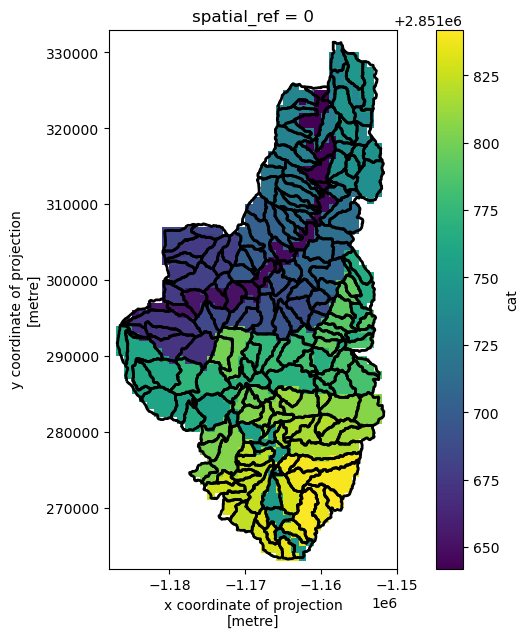

In [8]:
figure, ax = plt.subplots(figsize=(10,7))

# plot the gridded catchment mapping
ds_subset.cat.plot()

# preview map geometries
gdf.iloc[:].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

Plot the catchments of the subsetted area along with the buffered cells

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


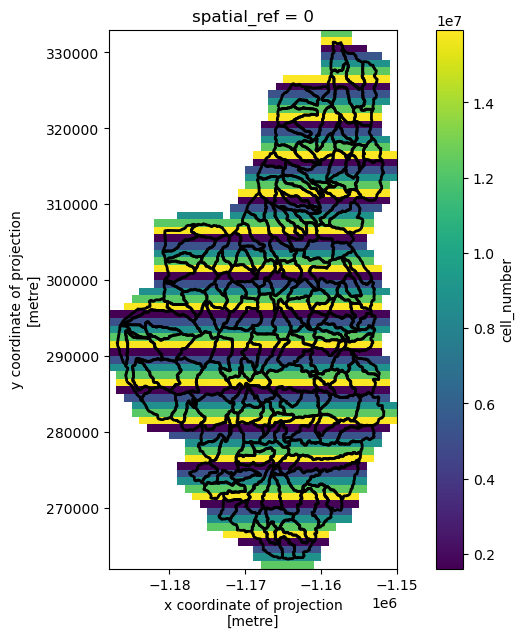

In [9]:
figure, ax = plt.subplots(figsize=(10,7))

# plot cell_number to show the buffered area that has been selected
ds_subset.cell_number.plot()

# preview map geometries
gdf.iloc[:].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

## Test using cell_number to compute weighted variables

In [ ]:
# read the pre-computed weights 
weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

In [ ]:
# isolate a single catchment that we're interested in
cat_id = 2851705

In [ ]:
# isolate a single catchment that we're interested in
cat_id = 2851705

# Select the cells that intersect with this boundary.
ds_catchment = ds.rio.clip(gdf.loc[gdf.divide_id == f'cat-{cat_id}'].geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

In [10]:
ds_subset.where(ds_subset.cat==cat_id, drop=True).cell_number

<xarray.DataArray 'cell_number' (y: 3, x: 2)> Size: 48B
array([[      nan, 12337556.],
       [15871893., 15876501.],
       [ 1716119.,  1720727.]])
Coordinates:
    lon          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
    lat          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
  * x            (x) float64 16B -1.164e+06 -1.163e+06
  * y            (y) float64 24B 3.025e+05 3.015e+05 3.005e+05
    spatial_ref  int64 8B 0
    cat          (y, x) float64 48B 2.852e+06 2.852e+06 ... 2.852e+06 2.852e+06

In [11]:
ds_catchment.cell_number

<xarray.DataArray 'cell_number' (y: 4, x: 4)> Size: 128B
array([[12328340., 12332948., 12337556.,       nan],
       [15867285., 15871893., 15876501., 15881109.],
       [ 1711511.,  1716119.,  1720727.,  1725335.],
       [      nan,       nan,  5259672.,  5264280.]])
Coordinates:
    lon          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
    lat          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
  * x            (x) float64 32B -1.165e+06 -1.164e+06 -1.163e+06 -1.162e+06
  * y            (y) float64 32B 3.025e+05 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(-1165453.7103159062, -1162568.241439442)

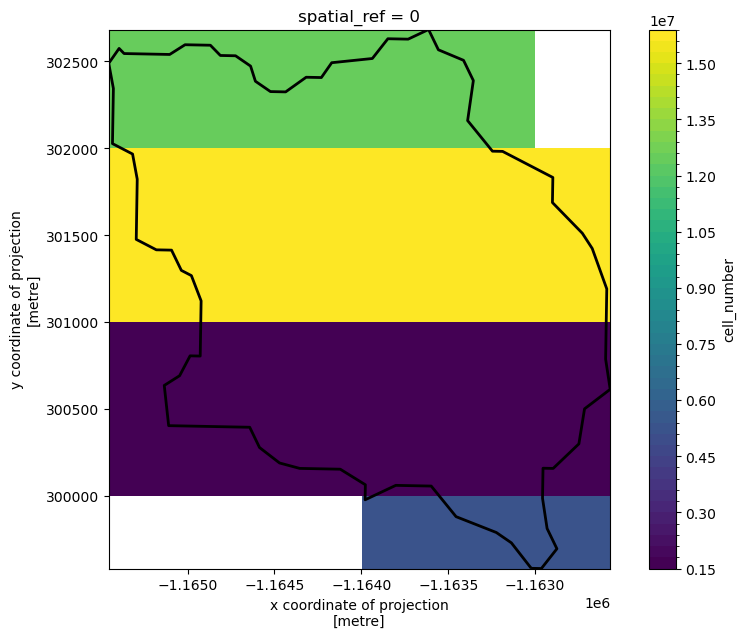

In [12]:
# todo: plot this catchment and the cells corresponding to the cell id.

figure, ax = plt.subplots(figsize=(10,7))


ds_catchment.cell_number.plot(levels=50)

# preview map geometries
current_geom = gdf.loc[gdf.divide_id == f'cat-{cat_id}']
gdf.loc[gdf.divide_id == f'cat-{cat_id}'].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item()
xmax = current_geom.geometry.bounds.maxx.item()
ymin = current_geom.geometry.bounds.miny.item()
ymax = current_geom.geometry.bounds.maxy.item()

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))

In [13]:
ds_catchment.cell_number

<xarray.DataArray 'cell_number' (y: 4, x: 4)> Size: 128B
array([[12328340., 12332948., 12337556.,       nan],
       [15867285., 15871893., 15876501., 15881109.],
       [ 1711511.,  1716119.,  1720727.,  1725335.],
       [      nan,       nan,  5259672.,  5264280.]])
Coordinates:
    lon          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
    lat          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
  * x            (x) float64 32B -1.165e+06 -1.164e+06 -1.163e+06 -1.162e+06
  * y            (y) float64 32B 3.025e+05 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0

In [14]:
catchment_weights = weights.loc[weights.divide_id == f'cat-{cat_id}'].sort_values(by='cell')

ids = numpy.unique(ds_catchment.cell_number)
ids.sort()
for cell in ids:
    print(f'{cell} in weights -> {cell in catchment_weights.cell}')

1711511.0 in weights -> False
1716119.0 in weights -> False
1720727.0 in weights -> False
1725335.0 in weights -> False
5259672.0 in weights -> False
5264280.0 in weights -> False
12328340.0 in weights -> False
12332948.0 in weights -> False
12337556.0 in weights -> False
15867285.0 in weights -> False
15871893.0 in weights -> False
15876501.0 in weights -> False
15881109.0 in weights -> False
nan in weights -> False


In [15]:
weights.loc[weights.divide_id == f'cat-{cat_id}'].sort_values(by='cell')

,divide_id,cell,coverage_fraction,grid_id
13796086,cat-2851705,7452275.0,0.239241,medium_range.forcing.conus
13796087,cat-2851705,7452276.0,0.464558,medium_range.forcing.conus
13796088,cat-2851705,7452277.0,0.374510,medium_range.forcing.conus
13796089,cat-2851705,7456883.0,0.178932,medium_range.forcing.conus
13796090,cat-2851705,7456884.0,0.983314,medium_range.forcing.conus
13796091,cat-2851705,7456885.0,0.986789,medium_range.forcing.conus
13796092,cat-2851705,7456886.0,0.240772,medium_range.forcing.conus
13796093,cat-2851705,7461491.0,0.035560,medium_range.forcing.conus
13796094,cat-2851705,7461492.0,0.725238,medium_range.forcing.conus
13796095,cat-2851705,7461493.0,0.980662,medium_range.forcing.conus


,id,divide_id,toid,type,ds_id,areasqkm,lengthkm,tot_drainage_areasqkm,has_flowline,geometry,cat
53,cat-2851705,cat-2851705,nex-2851649,network,None,6.02955,4.949371,6.02955,True,"POLYGON ((-1163022.554 299583.664, -1163136.80...",2851705


<xarray.DataArray 'cell_number' (y: 3, x: 2)> Size: 48B
array([[      nan, 12337556.],
       [15871893., 15876501.],
       [ 1716119.,  1720727.]])
Coordinates:
    lon          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
    lat          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
  * x            (x) float64 16B -1.164e+06 -1.163e+06
  * y            (y) float64 24B 3.025e+05 3.015e+05 3.005e+05
    spatial_ref  int64 8B 0
    cat          (y, x) float64 48B 2.852e+06 2.852e+06 ... 2.852e+06 2.852e+06

In [18]:
ymin.item()

299582.50405768957

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(-1165453.7103159062, -1162568.241439442)

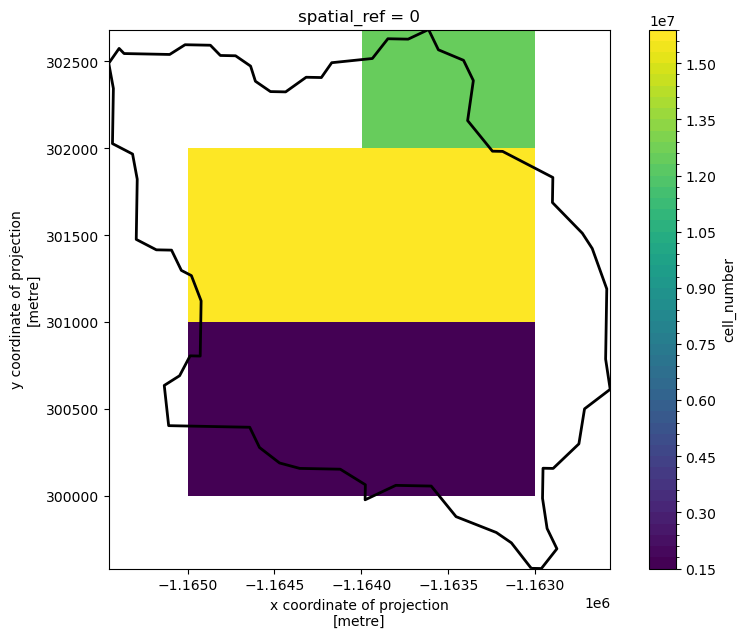

In [19]:
# todo: plot this catchment and the cells corresponding to the cell id.

figure, ax = plt.subplots(figsize=(10,7))


# plot the gridded catchment mapping
#ds_catchment.cat.plot()

ds_catchment.cell_number.plot(levels=50)

# preview map geometries
current_geom = gdf.loc[gdf.divide_id == f'cat-{cat_id}']
gdf.loc[gdf.divide_id == f'cat-{cat_id}'].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item()
xmax = current_geom.geometry.bounds.maxx.item()
ymin = current_geom.geometry.bounds.miny.item()
ymax = current_geom.geometry.bounds.maxy.item()

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))

In [20]:
ds_catchment.cell_number.count()

<xarray.DataArray 'cell_number' ()> Size: 8B
array(5)
Coordinates:
    spatial_ref  int64 8B 0

In [ ]:
weights.loc[weights.cell == 12337555]

In [ ]:
idxmin = weights.cell.sub(12335252.2120625).abs().idxmin()
weights.loc[idxmin]

In [ ]:
xs = ds_catchment.x.values

In [ ]:
ys = ds_catchment.y.values

In [ ]:
y = ys - dy/2
x = xs - dx/2

In [ ]:
(ymax - (y - dy/2)) / dy * ds_ncols + ((xs[0] - dx/2) - xmin) / dx

## Testing computing cell_values after subsetting region

In [ ]:
# clip AORC to the extent of the hydrofabric geometries
ds_catchment = ds.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

In [ ]:
# isolate a single catchment that we're interested in
cat_id = 2851705
subcatchment = ds.where(ds.cat==cat_id, drop=True)

In [ ]:
subcatchment

In [ ]:
wgrid = json.load(open('forcing_grids.json', 'r'))

In [ ]:
# only grab the x and y coordinates for a small region
xs = subcatchment.x.values
ys = subcatchment.y.values

# get the rest of the data from the large dataset
dx = ds.x.resolution
dy = ds.y.resolution
xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2 
ymin = ds.y.min().item() - dy / 2 
ymax = ds.y.max().item() + dy / 2 
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

In [ ]:
# unravel x, y coordinates into point pairs

rr, cc = numpy.meshgrid(xs, ys)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

In [ ]:
xss = pair_pts[:,0]
yss = pair_pts[:,1]

In [ ]:
#cell_number = ((ymax - (yss)) / dy * ds_ncols + ((xss) - xmin) / dx).round()
#cell_number = ((ymax - (yss - dy/2)) / dy * ds_ncols + ((xss- dy/2) - xmin) / dx).round()
cell_number = (ymax - (yss - dy/2)) / dy * ds_ncols + ((xss- dy/2) - xmin) / dx

In [ ]:
cell_ids = cell_number.reshape(ds_nrows, ds_ncols)
cell_ids.shape

In [ ]:
cell_number

In [ ]:
cell_number

In [ ]:
weights.loc[weights.divide_id == f'cat-{cat_id}']

In [ ]:
weights.loc[weights.cell.isin(cell_number)]